HDF5 is a direct, easy path to "big" (or just annoyingly larger than RAM) data in scientific python. Using the HDF5 file format and careful coding of your algorithms, it is quite possible to process "big-ish" data on modest hardware, and really push your resources to the limit before moving to larger, fancier distributed platforms. 

There are two primary options for working with HDF5 files in python: H5Py and [PyTables](http://www.pytables.org/). While many people enjoy H5Py, I am much more familiar with PyTables and prefer it for most tasks. This blog will show a variety of PyTables examples for several potential applications including standard numpy nd-array replacement, variable length (ragged) arrays, iterator rewriting for simpler retireval of data, and on-the-fly compression/decompression.
<!-- TEASER_END -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

To test our various techniques for storing data in HDF5, first we need some data to store. Here I have created a quick function which will generate random data from four clusters, as well as returning the cluster label for each datapoint. This data generator should be sufficient for testing all the PyTables techniques I will show in this post.

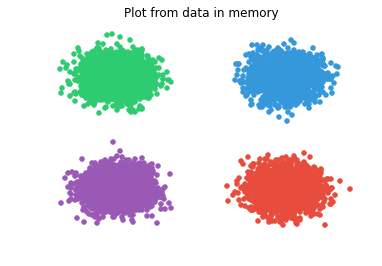

In [2]:
random_state = np.random.RandomState(1999)

def make_random_cluster_points(n_samples, random_state=random_state):
    mu_options = np.array([(-1, -1), (1, 1), (1, -1), (-1, 1)])
    sigma = 0.2
    mu_choices = random_state.randint(0, len(mu_options), size=n_samples)
    means = mu_options[mu_choices]
    return means + np.random.randn(n_samples, 2) * sigma, mu_choices

def plot_clusters(data, clusters, name):
    plt.figure()
    colors = ["#9b59b6", "#3498db", "#e74c3c", "#2ecc71"]
    for i in np.unique(clusters):
        plt.scatter(data[clusters==i, 0], data[clusters==i, 1], color=colors[i])
    plt.axis('off')
    plt.title('Plot from %s' % name)

data, clusters = make_random_cluster_points(10000)
plot_clusters(data, clusters, "data in memory")

First, a brief high level discussion of how HDF5 and PyTables work. I think the website says it best:

>PyTables is a package for managing hierarchical datasets and designed to efficiently and easily cope with extremely large amounts of data. You can download PyTables and use it for free [...] One important feature of PyTables is that it optimizes memory and disk resources so that data takes much less space (specially if on-flight compression is used) than other solutions such as relational or object oriented databases.

PyTables allows us to quickly and easily deal with large volumes of on-disk data, while largely keeping the complexity of the data storage invisible to the downstream processing in numpy, scipy, theano, etc. Depending on the algorithms used downstream, you can sometimes drop in hdf5 data to replace a numpy array and everything will keep working exactly like before - when this happens it is quite an amazing feeling.

First we will start with the simplest use for HDF5 - data persistence. We will show this using two types of [Arrays](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-array-class) provided by PyTables - Array and CArray.

We take the following steps below:
1. Importing PyTables with ``import tables``
2. Creating some data
3. Creating a new hdf5 file (or overwriting the old oneat the same place!)
4. Adding a PyTables ``Array`` to hold the data, and storing our data in it

In [3]:
import tables

sample_data, sample_clusters = make_random_cluster_points(10000)
hdf5_path = "my_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
data_storage = hdf5_file.createArray(hdf5_file.root, 'data', sample_data)
clusters_storage = hdf5_file.createArray(hdf5_file.root, 'clusters', sample_clusters)
hdf5_file.close()

Now we can open the fil, and use the data in it for the same things that we used the old arrays for. Make sure to notice that we are slicing (using [:]) the ``data`` and ``clusters`` back into memory so that we can use these variables for plotting. More on this in a moment.

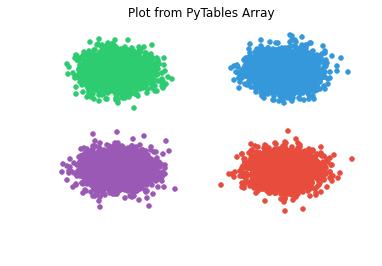

In [4]:
hdf5_path = "my_data.hdf5"
read_hdf5_file = tables.openFile(hdf5_path, mode='r')
# Here we slice [:] all the data back into memory, then operate on it
hdf5_data = read_hdf5_file.root.data[:]
hdf5_clusters = read_hdf5_file.root.clusters[:]
read_hdf5_file.close()

plot_clusters(hdf5_data, hdf5_clusters, "PyTables Array")

So why did we need to slice the data in order to use it? This comes from the way that PyTables manages on-disk versus in memory data. 

A PyTables array lives on disk until some data is sliced out using standard numpy notation. At that point, the data slice is read into memory from the disk, for the lifetime of that slice. Once the slice is finished being used, the python garbage collector will try to free the memory of the slice and any changes (if you made them) can be written back to the PyTables array on disk.

This makes PyTables a nearly transparent drop in for numpy arrays which are larger than memory but only need to be processed a little bit at a time. For my own usage, I typically have some separate scripts to preprocess and write data to an hdf5 file, and all algorithmic processing scripts open this as read only - this is very similar to what we have seen above. 

Compression using CArray
=============

Now that we have seen a basic array, we can take a look at using a compressed array, the [CArray](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-carray-class). PyTables makes it really easy to store and read compressed data from disk.

In [5]:
sample_data, sample_clusters = make_random_cluster_points(10000)
hdf5_path = "my_compressed_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
filters = tables.Filters(complevel=5, complib='blosc')
data_storage = hdf5_file.createCArray(hdf5_file.root, 'data',
                                      tables.Atom.from_dtype(sample_data.dtype),
                                      shape=sample_data.shape,
                                      filters=filters)
clusters_storage = hdf5_file.createCArray(hdf5_file.root, 'clusters',
                                          tables.Atom.from_dtype(sample_clusters.dtype),
                                          shape=sample_clusters.shape,
                                          filters=filters)
data_storage[:] = sample_data
clusters_storage[:] = sample_clusters
hdf5_file.close()

Here we have introduced a few more key PyTables constructs: [compression filters](http://www.pytables.org/usersguide/libref/helper_classes.html#tables.Filters) and [Atom](http://www.pytables.org/usersguide/libref/declarative_classes.html#atomclassdescr) types. 

Compression filters are incredibly easy to use, and can provide a massive benefit to through put and disk usage. Usage is as simple as what I showed above - simply define a filter and then use it when creating any of the compressible arrays (CArray, EArray (to be introduced)).
```
filters = tables.Filters(complevel=5, complib='blosc')
```
Arguments for complib are ``blosc``, ``zlib``, and ``lzo`` , with ``blosc`` being my goto compressor. There is a very in depth discussion of different compression algorithms [here](http://www.pytables.org/usersguide/optimization.html?highlight=optimization#compressionissues). If you are really tuning PyTables and HDF5 for your application, I highly advise you to look there - but in general ``blosc`` is great, and can make your disk I/O effectively faster than streaming raw bytes.

Atoms are a special construct of PyTables which allow you to specify dtypes when creating Arrays. There are several methods such as ``tables.Atom.from_dtype`` which can help you set the dtype, or it is easy to manually specify one using one of the [listed types](http://www.pytables.org/usersguide/libref/declarative_classes.html#atomclassdescr) such as ``tables.Atom.Float32()``.

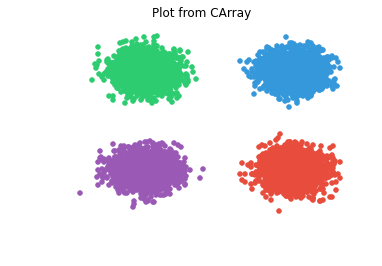

In [6]:
hdf5_path = "my_compressed_data.hdf5"
compressed_hdf5_file = tables.openFile(hdf5_path, mode='r')
# Here we slice [:] all the data back into memory, then operate on it
uncompressed_hdf5_data = compressed_hdf5_file.root.data[:]
uncompressed_hdf5_clusters = compressed_hdf5_file.root.clusters[:]
compressed_hdf5_file.close()

plot_clusters(uncompressed_hdf5_data, uncompressed_hdf5_clusters, "CArray")

Next Stop, EArray
==========
So far, so good (so what). I can already anicipate questions such as "My data won't fit into memory at all... how can I get it into a PyTables array"?

Fear not, the [EArray](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-earray-class) is here to save the day! This is the workhorse Array type, and the one I use for 99% of my PyTables usage. It is compressible *and* extendable using the ``append`` method. Barring a few special exceptions, the EArray can take care of most data storage needs - lets see how it works.

In [7]:
hdf5_path = "my_extendable_compressed_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
filters = tables.Filters(complevel=5, complib='blosc')
data_storage = hdf5_file.createEArray(hdf5_file.root, 'data',
                                      tables.Atom.from_dtype(sample_data.dtype),
                                      shape=(0, sample_data.shape[-1]),
                                      filters=filters,
                                      expectedrows=len(sample_data))
clusters_storage = hdf5_file.createEArray(hdf5_file.root, 'clusters',
                                          tables.Atom.from_dtype(sample_clusters.dtype),
                                          shape=(0,),
                                          filters=filters,
                                          expectedrows=len(sample_clusters))
for n, (d, c) in enumerate(zip(sample_data, sample_clusters)):
    data_storage.append(sample_data[n][None])
    clusters_storage.append(sample_clusters[n][None])
hdf5_file.close()

After adding data and (lossless-ly) compressing using EArray, we want to be sure that data retrieval is easy. Plotting the clusters should take care of this, and we do it just as we did for the CArray. In addition, we can also slice subsets of the EArray (e.g. *hdf5_file.root.data[10:100]*) which only brings *that portion* of the data into memory. For dealing with very large datasets this is extremely useful - only the sliced data is ever in memory, and python will get rid of the memory once the slice is not used anymore.

You can control memory usage by how much data is sliced out of an EArray, and python will clean up after you are done using that slice. The data stays on disk, so you can fetch it again if needed. 

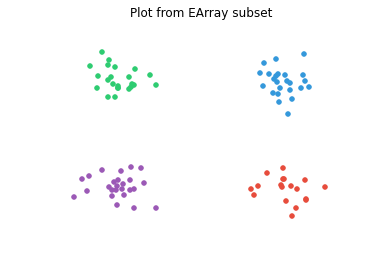

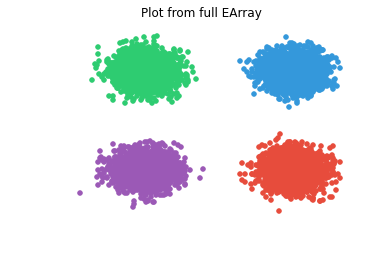

In [8]:
hdf5_path = "my_extendable_compressed_data.hdf5"
extendable_hdf5_file = tables.openFile(hdf5_path, mode='r')
extendable_hdf5_data = extendable_hdf5_file.root.data[:]
extendable_hdf5_clusters = extendable_hdf5_file.root.clusters[:]
plot_clusters(extendable_hdf5_file.root.data[10:100],
              extendable_hdf5_file.root.clusters[10:100], "EArray subset")
plot_clusters(extendable_hdf5_data, extendable_hdf5_clusters, "full EArray")
extendable_hdf5_file.close()

We can also open old hdf5 files created with PyTables, and add new data into an EArray. For example, if you were processing daily data from a point-of-sale application an hdf5 file could be used to store new information as it comes in. As a bonus, your sysadmin/DBA people will have a heart attack because you are not using databases/backups... but I digress. hdf5 files are really great for something that is basically a numpy array, but much too large to fit in memory.

In [9]:
hdf5_path = "my_extendable_compressed_data.hdf5"
extendable_hdf5_file = tables.openFile(hdf5_path, mode='a')
extendable_hdf5_data = extendable_hdf5_file.root.data
extendable_hdf5_clusters = extendable_hdf5_file.root.clusters
print("Length of current data: %i" % len(extendable_hdf5_data))
print("Length of current cluster labels: %i" % len(extendable_hdf5_clusters))
n_added = 5
print("Now adding %i elements to each" % n_added)
for n, (d, c) in enumerate(zip(sample_data[:n_added], sample_clusters[:n_added])):
    extendable_hdf5_data.append(sample_data[n][None])
    extendable_hdf5_clusters.append(sample_clusters[n][None])
extendable_hdf5_file.close()

extendable_hdf5_file = tables.openFile(hdf5_path, mode='r')
print("Length of current data: %i" % len(extendable_hdf5_file.root.data))
print("Length of current cluster labels: %i" % len(extendable_hdf5_file.root.clusters))
extendable_hdf5_file.close()

Length of current data: 10000
Length of current cluster labels: 10000
Now adding 5 elements to each
Length of current data: 10005
Length of current cluster labels: 10005


EArray is incredibly flexible, and allows for easy numpy array-style data. There are some issues with variable length storage which can be solved by something called VLArray, or by fancy methods on top of EArray which I will discuss later.

Ragged Data with VLArray
=============

There is one more type of array which is very useful for variable length data like speech (utterances) or text (sentences) - the [VLArray](http://www.pytables.org/usersguide/libref/homogenous_storage.html#the-vlarray-class). Though it does not support compression of the data (see note in the above documentation) it is still useful in many cases, and is definitely the simplest way to handle variable length data.

In [10]:
hdf5_path = "my_variable_length_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
data_storage = hdf5_file.createVLArray(hdf5_file.root, 'data',
                                       tables.Float32Atom(shape=()))
clusters_storage = hdf5_file.createVLArray(hdf5_file.root, 'clusters',
                                           tables.Int32Atom(shape=()))
random_state = np.random.RandomState(1999)
for n in range(1000):
    length = int(100 * random_state.randn() ** 2)
    data_storage.append(random_state.randn(length,))
    clusters_storage.append([length % random_state.randint(1, 5)])
hdf5_file.close()

To test the variable length approach we have done a few things above. For data_storage, we created a random length float vector between length 0 and ~2000, in order to simulate variable length data which is distributed approximately exponentially, which is common for things like text (google [Zipf's law](http://www.hermetic.ch/wfca/zipf.htm) for more details). The clusters remained fixed size, but needed to be a sequence, so we wrapped it in the [] braces which made a list out of the single random integer either 1, 2, 3, or 4.
This data doesn't really mean anything, but plotting the lengths clearly shows that we can store variable length data in an hdf5 container quite easily. This is very useful for raw text and raw speech, though it has limitations as well - namely that it does not handle multi-dimensional arrays!

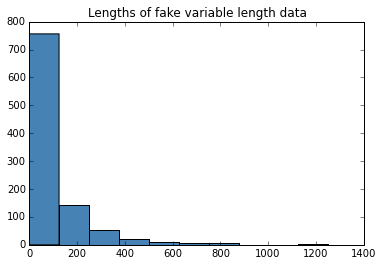

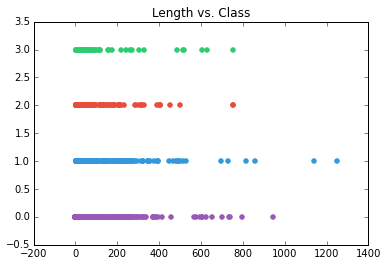

In [11]:
hdf5_path = "my_variable_length_data.hdf5"
variable_hdf5_file = tables.openFile(hdf5_path, mode='r')
variable_hdf5_data = variable_hdf5_file.root.data
variable_hdf5_clusters = variable_hdf5_file.root.clusters
all_lengths = np.array([len(d) for d in variable_hdf5_data])
plt.hist(all_lengths, color="steelblue")
plt.title("Lengths of fake variable length data")
plt.figure()
clusters = variable_hdf5_clusters
colors = ["#9b59b6", "#3498db", "#e74c3c", "#2ecc71"]
for i in np.unique(clusters):
    plt.scatter([len(d) for d in variable_hdf5_data[(clusters==i).ravel()]],
                clusters[(clusters==i).ravel()], color=colors[i])
plt.title("Length vs. Class")
plt.show()   
variable_hdf5_file.close()

Advanced PyTables - the best of both worlds?
========================

We have seen EArray, which provides an extendable array in one dimension and can also be compressed and decompressed on the fly to improve "effective" disk speed and reduce size on the hard disk drive. We have also seen VLArray, which allows for storing "ragged" data which is variable length in one dimension (dimension 2). Is there a way we can store variables which are variable size *and* retain compression?

**Yes** - by overriding \_\_getitem\_\_ and some other special tricks, we can do a number of interesting things to PyTables arrays (primarily EArray) including compressed arbitrary shape data, memory caching, and more. First up, reshaping on the fly to store ragged arrays with multiple dimensions in a VLArray.

In [12]:
hdf5_path = "my_nd_variable_length_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
data_storage = hdf5_file.createVLArray(hdf5_file.root, 'data',
                                       tables.Float32Atom(shape=()))
data_shapes_storage = hdf5_file.createEArray(hdf5_file.root, 'data_shape',
                                             tables.Int32Atom(),
                                             shape=(0, 2),
                                             expectedrows=1000)
random_state = np.random.RandomState(1999)
for n in range(1000):
    shape = (int(100 * random_state.randn() ** 2), random_state.randint(2, 10))
    data_storage.append(random_state.randn(*shape).ravel())
    data_shapes_storage.append(np.array(shape)[None])
hdf5_file.close()

Thinking about the way numpy actually stores data, we can use the same trick to store n-dimensional variables in a VLArray.

If you are not familiar with the way numpy handles data internally, it is pretty awesome. Basically, there are 2 parts to a numpy array - the data, and an iterator over that data. The data is stored "flat", regardless of the value of ``shape``. This means that *any* valid reshape is simply rewriting the iterator, rather than copying all data.

<img src="numpy_data_layout.png", align="right", width="50%", height="50%">
Each of the colored cells have the same actual value, but there are several valid "views" onto the same data. We can create these views onto the underlying data using ``reshape``.

Knowing this, we can apply the same trick to VLArray. By storing a flattened version of the numpy array (using ``ravel`` or ``flatten``) *and* the shape associated with that index (which is a usually constant size, in this case 2D) we can reconstruct arbitrary shaped data by overriding \_\_getitem\_\_, which is generally a special python method that controls what happens what the bracket operator ([]) is used.

In [13]:
hdf5_path = "my_nd_variable_length_data.hdf5"
nd_variable_hdf5_file = tables.openFile(hdf5_path, mode='r')
nd_variable_hdf5_data = nd_variable_hdf5_file.root.data
nd_variable_hdf5_shape = nd_variable_hdf5_file.root.data_shape

old_data_getter = nd_variable_hdf5_file.root.data.__getitem__
shape_getter = nd_variable_hdf5_file.root.data_shape.__getitem__

First we want to open the hdf5 file and get some shorter names for things we are going to use. We also want to "save" the old way that data fetching used to work (old_data_getter) to make our new data getter, which does reshaping for you. Next will define a *new* getter which will be used to fetch data and reshape internally. The first argument (self) shows that eventually we will make this a *class method* in order to make the reshape transparent - but first we need to define what behavior we want.

In [14]:
import numbers

def getter(self, key):
    if isinstance(key, numbers.Integral) or isinstance(key, np.integer):
        start, stop, step = self._processRange(key, key, 1)
        if key < 0:
            key = start
        return old_data_getter(key).reshape(shape_getter(key))
    elif isinstance(key, slice):
        start, stop, step = self._processRange(key.start, key.stop, key.step)
        raise ValueError("Variable length - what should we do?")

Now we can check that the getter fetches data from the old getter and reshapes it, and see that the shape matches what we originally stored.

In [15]:
print(getter(nd_variable_hdf5_data, -1).shape)
print(nd_variable_hdf5_data[-1].shape)
print(nd_variable_hdf5_shape[-1])

(84, 7)
(588,)
[84  7]


We can fetch one key - no problem. But what shold be done to fetch a slice (chunk) of variable length data? We can't really put them into a 2D array unless we pad all of them to the same length, or pass back a list of arrays approach. The method taken depends on your bias, but I personally prefer a list of arrays approach, as you can always pad later. Given this bias, let's update the getter functionality and get it "attached" to the VLArray instance to override \_\_getitem\_\_.

In [16]:
def getter(self, key):
    if isinstance(key, numbers.Integral) or isinstance(key, np.integer):
        start, stop, step = self._processRange(key, key, 1)
        if key < 0:
            key = start
        return old_data_getter(key).reshape(shape_getter(key))
    elif isinstance(key, slice):
        start, stop, step = self._processRange(key.start, key.stop, key.step)
        return [old_data_getter(k).reshape(shape_getter(k)) for k in range(start, stop, step)]

For now, we have to use a python slice() object to test. Once we attach this getter to the data we will be able to use the familiar slice syntax - but for now just know ``slice(start, stop, step)`` is equivalent to ``[start:stop:step]``. This will return a list of arrays which we can then process using whatever algorithm we choose.

In [17]:
list_of_ragged_arrays = getter(nd_variable_hdf5_data, slice(-5, -1, 1))
print([d.shape for d in list_of_ragged_arrays])

[(11, 8), (71, 2), (29, 5), (97, 2)]


Having done this work, we now need to add this functionaluty to the VLArray instance holding our data. It turns out this is pretty tricky (for reasons involving monkeypatching, c-extensions, and other Python business) - the only way I have found is to create a *fake* subclass, then change *all* instances of that subclass (which should be only this data) to fetch data using this special getter function. It is definitely not perfect, but it works.

Here it is also important to note that ``shape`` of this ragged array storage is actually uninformative - ``len(data)`` is the best way to see the number of samples, but since every example has a different shape you can't really look at ``shape`` for the data as a whole. This is a somewhat obvious point in hindsight, but it can bite you in your code, so be sure to be aware.

In [18]:
class _my_VLArray_subclass(tables.VLArray):
    pass

nd_variable_hdf5_file.root.data.__class__ = _my_VLArray_subclass
_my_VLArray_subclass.__getitem__ = getter

print(nd_variable_hdf5_data[-1].shape)
list_of_ragged_arrays = nd_variable_hdf5_data[-5:-1]
print([d.shape for d in list_of_ragged_arrays])

(84, 7)
[(11, 8), (71, 2), (29, 5), (97, 2)]


We can see that the shapes here are the same as the shapes above - by implementing a custom getter we have invisibly allowed ourselves to store "multi-ragged" (for lack of a better term) data in VLArray.

Compression and multi-ragged variables using EArray
============================

Now that we have figured out how to "patch" objects to use custom getters, how can we use this to store variable length data (like text) in a compressible way? It turns out that we can introduce another "side column" that lets us do what VLArray does, except with EArray! Let's see it in action.

In [19]:
hdf5_path = "my_earray_variable_length_data.hdf5"
hdf5_file.close()
hdf5_file = tables.openFile(hdf5_path, mode='w')
filters = tables.Filters(complevel=5, complib='blosc')
data_storage = hdf5_file.createEArray(hdf5_file.root, 'data',
                                      tables.Int32Atom(),
                                      shape=(0,),
                                      filters=filters,
                                      # guess that there will mean of 50 numbers
                                      # per sample
                                      expectedrows=50 * 1000)
data_start_and_stop_storage = hdf5_file.createEArray(hdf5_file.root,
                                                     'data_start_and_stop',
                                                     tables.Int32Atom(),
                                                     shape=(0, 2),
                                                     filters=filters)
data_shape_storage = hdf5_file.createEArray(hdf5_file.root,
                                            'data_shape',
                                            tables.Int32Atom(),
                                            shape=(0, 2),
                                            filters=filters)
random_state = np.random.RandomState(1999)
start = 0
stop = 0
for n in range(1000):
    shape = random_state.randint(2, 10, 2)
    length = shape[0] * shape[1]
    # fake 2D array of ints (pseudo images) 
    fake_image = random_state.randint(0, 256, length)
    for i in range(len(fake_image)):
        data_storage.append(fake_image[i][None])
    stop = start + length  # Not inclusive!
    data_start_and_stop_storage.append(np.array((start, stop))[None])
    data_shape_storage.append(np.array((shape))[None])
    start = stop
hdf5_file.close()

Now that we have created some fake data, we will begin the same procedure - open the file, create a fake getter, and use that fake getter to transform the data into a representation we want. 

The key difference between this approach and the earlier approach is that we need to have something that works with EArray - the most obvious way (once again borrowing concepts from numpy memory layout) is to put the *entire* data into 1 long chunk, then index into that chunk to slice out the flattened samples, then reshaping those based on the true shape, we can get the actual values we desire. By tracking the start and stop of each flattened sample as well as the true shape, we can achieve this.

In [20]:
hdf5_path = "my_earray_variable_length_data.hdf5"
earray_variable_hdf5_file = tables.openFile(hdf5_path, mode='r')
earray_variable_hdf5_data = earray_variable_hdf5_file.root.data
earray_variable_hdf5_start_and_stop = earray_variable_hdf5_file.root.data_start_and_stop
earray_variable_hdf5_shape = earray_variable_hdf5_file.root.data_shape

print("Length of flattened data (*not* n_samples!) %i" % len(earray_variable_hdf5_data))
print("Length of shapes (actual n_samples) %i" % len(earray_variable_hdf5_shape))
print("Length of start and stop (actual n_samples) %i" % len(earray_variable_hdf5_shape))

Length of flattened data (*not* n_samples!) 29960
Length of shapes (actual n_samples) 1000
Length of start and stop (actual n_samples) 1000


In [21]:
old_data_getter = earray_variable_hdf5_file.root.data.__getitem__
shape_getter = earray_variable_hdf5_file.root.data_shape.__getitem__
start_and_stop_getter = earray_variable_hdf5_file.root.data_start_and_stop.__getitem__
def getter(self, key):
    if isinstance(key, numbers.Integral) or isinstance(key, np.integer):
        if key < 0:
            key = len(earray_variable_hdf5_shape) + key
        data_start, data_stop = start_and_stop_getter(key)
        shape = shape_getter(key)
        return old_data_getter(slice(data_start, data_stop, 1)).reshape(shape)
    elif isinstance(key, slice):
        start = key.start if key.start is not None else 0
        stop = key.stop if key.stop is not None else len(earray_variable_hdf5_shape)
        step = key.step if key.step is not None else 1
        pos_keys = [len(earray_variable_hdf5_shape) + k if k < 0 else k
                    for k in range(start, stop, step)]
        starts_and_stops = [start_and_stop_getter(k) for k in pos_keys]
        shapes = [shape_getter(k) for k in pos_keys]
        return [old_data_getter(slice(dstrt, dstp, 1)).reshape(shp)
                for ((dstrt, dstp), shp) in zip(starts_and_stops, shapes)]
print("Testing single key %s" % str(getter(earray_variable_hdf5_data, -1).shape))
print("Testing slice %i" % len(getter(earray_variable_hdf5_data, slice(-20, -1, 1))))
                                                                
class _my_EArray_subclass(tables.EArray):
    pass
earray_variable_hdf5_file.root.data.__class__ = _my_EArray_subclass
_my_EArray_subclass.__getitem__ = getter
_my_EArray_subclass.__len__ = earray_variable_hdf5_shape.__len__
print(earray_variable_hdf5_data[-2].shape)
print(len(earray_variable_hdf5_data))
print(len(earray_variable_hdf5_data[-20:-1]))

Testing single key (5, 2)
Testing slice 19
(9, 5)
1000
19


In [22]:
all_points = sum([shp[0] * shp[1] for shp in earray_variable_hdf5_shape])
print("Total number of datapoints %i" % all_points)
print("kB for raw storage %f" % ((all_points * 4.) / float(1E3)))
!ls -lh my_earray_variable*.hdf5

Total number of datapoints 29960
kB for raw storage 119.840000
-rw-r--r--  1 User  staff    47K Aug  4 07:59 my_earray_variable_length_data.hdf5


Naive calculation of this data shows that for uncompressed storage of 29960 int32 values, this is raw storage of (4 bytes per int32 x 29960 int32 points) = 119.840 kB. But looking at the actual storage, we use less than 50% of that *even* with the extra data needed for start, stop and shape. This 50% gain in storage *also* equates to effectively ~50% faster reads from disk - awesome! It's like buying new hardware without spending any money.

The only downside is that decompressing on the fly will use *more* CPU than reading the data from disk raw - but in general this overhead is much less than the gain you get from reading data from disk 50% faster. In general we have much more CPU available than excess disk read throughput, though this starts changing if you have an SSD.

One More Trick
========

There is one more area we can optimize - memory usage. By reading more data into memory at a time, we can improve processing times by hitting the disk less often, and reading longer continuous reads. For spinning disk, this is the best way to read a file - since it is spinning in circles you are just reading the bits in order rather than having to spin the disk back and forth.

HDF5/pytables support some of this in memory processing, but the rest can be done using getter override tricks like we have seen above. First, let's see how we can do an in-memory hdf5 file, using ``H5D_core``.

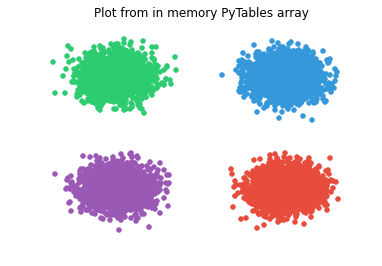

In [23]:
sample_data, sample_clusters = make_random_cluster_points(10000)
hdf5_path = "my_inmemory_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
data_storage = hdf5_file.createArray(hdf5_file.root, 'data', sample_data)
clusters_storage = hdf5_file.createArray(hdf5_file.root, 'clusters', sample_clusters)
hdf5_file.close()

hdf5_path = "my_inmemory_data.hdf5"
read_hdf5_file = tables.openFile(hdf5_path, mode='r', driver='H5FD_CORE')
hdf5_data = read_hdf5_file.root.data[:]
hdf5_clusters = read_hdf5_file.root.clusters[:]
read_hdf5_file.close()

plot_clusters(hdf5_data, hdf5_clusters, "in memory PyTables array")

Now, we would also like to be able to trade off memory usage for access speed for something in between ``H5FFD_CORE`` and slices \[:\] from the dataset. For sequential access (like iterating minibatches for KMeans, neural networks, etc.) this can be achieved using some special getter tricks. One example of this can be seen in my library [dagbldr](https://github.com/dagbldr/dagbldr/blob/master/dagbldr/datasets/dataset_utils.py#L5). I will post a function from that library here for completeness, but in general the latest version (and other tricks) will be found in my library.

In [24]:
def add_memory_swapper(earray, mem_size):
    class _cEArray(tables.EArray):
        pass

    # Filthy hack to override getter which is a cextension...
    earray.__class__ = _cEArray

    earray._in_mem_size = int(float(mem_size))
    assert earray._in_mem_size >= 1E6 # anything smaller than 1MB is pretty worthless
    earray._in_mem_slice = np.empty([1] * len(earray.shape)).astype("float32")
    earray._in_mem_limits = [np.inf, -np.inf]

    old_getter = earray.__getitem__

    def _check_in_mem(earray, start, stop):
        lower = earray._in_mem_limits[0]
        upper = earray._in_mem_limits[1]
        if start < lower or stop > upper:
            return False
        else:
            return True

    def _load_in_mem(earray, start, stop):
        # start and stop are slice indices desired - we calculate different
        # sizes to put in memory
        n_bytes_per_entry = earray._in_mem_slice.dtype.itemsize
        n_entries = earray._in_mem_size / float(n_bytes_per_entry)
        n_samples = earray.shape[0]
        n_other = earray.shape[1:]
        n_samples_that_fit = int(n_entries / np.prod(n_other))
        assert n_samples_that_fit > 0
        # handle - index case later
        assert start >= 0
        assert stop >= 0
        assert stop >= start
        slice_size = stop - start
        if slice_size > n_samples_that_fit:
            err_str = "Slice from [%i:%i] (size %i) too large! " % (start, stop, slice_size)
            err_str += "Max slice size %i" % n_samples_that_fit
            raise ValueError(err_str)
        slice_limit = [start, stop]
        earray._in_mem_limits = slice_limit
        if earray._in_mem_slice.shape[0] == 1:
            # allocate memory
            print("Allocating %i bytes of memory for EArray swap buffer" % earray._in_mem_size)
            earray._in_mem_slice = np.empty((n_samples_that_fit,) + n_other, dtype=earray.dtype)
        # handle edge case when last chunk is smaller than what slice will
        # return
        limit = min([slice_limit[1] - slice_limit[0], n_samples - slice_limit[0]])
        earray._in_mem_slice[:limit] = old_getter(
            slice(slice_limit[0], slice_limit[1], 1))

    def getter(self, key):
        if isinstance(key, numbers.Integral) or isinstance(key, np.integer):
            start, stop, step = self._processRange(key, key, 1)
            if key < 0:
                key = start
            if _check_in_mem(self, key, key):
                lower = self._in_mem_limits[0]
            else:
                # slice into memory...
                _load_in_mem(self, key, key)
                lower = self._in_mem_limits[0]
            return self._in_mem_slice[key - lower]
        elif isinstance(key, slice):
            start, stop, step = self._processRange(key.start, key.stop, key.step)
            if _check_in_mem(self, start, stop):
                lower = self._in_mem_limits[0]
            else:
                # slice into memory...
                _load_in_mem(self, start, stop)
                lower = self._in_mem_limits[0]
            return self._in_mem_slice[start - lower:stop - lower:step]
    # This line is critical...
    _cEArray.__getitem__ = getter
    return earray

After defining this function, we should be able to add a memory swapper onto an EArray and transparently control the amount of CPU memory we use to speed up processing - giving us a tradeoff between memory usage and prcessing speed which is one of the most common trade-offs made in programming. Depending on your hardware, anywhere from "only a slice at a time" as in regular HDF5, to "all in memory" as by having a large value in ``add_memory_swapper`` or using the ``H5FD_CORE`` driver when opening the file is available to trade through.

Allocating 10000000 bytes of memory for EArray swap buffer


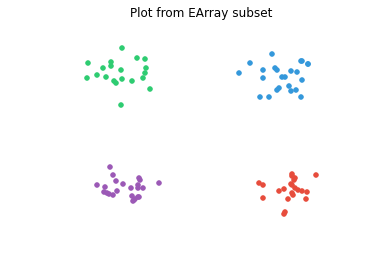

In [25]:
hdf5_path = "my_memory_extendable_compressed_data.hdf5"
hdf5_file = tables.openFile(hdf5_path, mode='w')
filters = tables.Filters(complevel=5, complib='blosc')
data_storage = hdf5_file.createEArray(hdf5_file.root, 'data',
                                      tables.Atom.from_dtype(sample_data.dtype),
                                      shape=(0, sample_data.shape[-1]),
                                      filters=filters,
                                      expectedrows=len(sample_data))
clusters_storage = hdf5_file.createEArray(hdf5_file.root, 'clusters',
                                          tables.Atom.from_dtype(sample_clusters.dtype),
                                          shape=(0,),
                                          filters=filters,
                                          expectedrows=len(sample_clusters))
for n, (d, c) in enumerate(zip(sample_data, sample_clusters)):
    data_storage.append(sample_data[n][None])
    clusters_storage.append(sample_clusters[n][None])
hdf5_file.close()

hdf5_path = "my_memory_extendable_compressed_data.hdf5"
memory_extendable_hdf5_file = tables.openFile(hdf5_path, mode='r')
memory_extendable_hdf5_data = add_memory_swapper(memory_extendable_hdf5_file.root.data, 10E6)
memory_extendable_hdf5_clusters = memory_extendable_hdf5_file.root.clusters
plot_clusters(memory_extendable_hdf5_file.root.data[10:100],
              memory_extendable_hdf5_file.root.clusters[10:100], "EArray subset")

After reading the data, we can look at the memory limits used internally by the memory swapper. After taking different slices we see the ``_in_mem_limits`` move - this means the swapper is reading new data from disk into memory. However, taking a slice which is already in memory will not invoke another copy from disk.

In [26]:
print("Current memory limits %s" % str(memory_extendable_hdf5_data._in_mem_limits))
memory_extendable_hdf5_data[-100:]
print("Moved memory limits %s" % str(memory_extendable_hdf5_data._in_mem_limits))
memory_extendable_hdf5_data[-5:]
print("Unchanged memory limits %s" % str(memory_extendable_hdf5_data._in_mem_limits))
memory_extendable_hdf5_file.close()

Current memory limits [10, 100]
Moved memory limits [9900, 10000]
Unchanged memory limits [9900, 10000]


We can see that using HDF5 with pytables makes almost any operation possible, even on low memory hardware. By playing some advanced tricks with \_\_getitem\_\_ it is possible to create containers which compress lots of data into small storage, helping us process from disk faster giving more effective throughput for a system. In addition, we can also use these same tricks to trade memory for speed for uniform 2D arrays, with easy extension to arbitrary nd-array processing.

kk